In [ ]:
# !pip install git+https://github.com/SMTOrg/smt.git

  Cloning https://github.com/SMTOrg/smt.git to /tmp/pip-req-build-rv5gzevi
  Running command git clone --filter=blob:none --quiet https://github.com/SMTOrg/smt.git /tmp/pip-req-build-rv5gzevi
  Resolved https://github.com/SMTOrg/smt.git to commit f510e994dd5874558b11d3a73fa92d8f6cf30359
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for smt: filename=smt-2.7.0-cp310-cp310-linux_x86_64.whl size=725486 sha256=5d6c3f3ffe22678dc7c034655a51b58933c382890a48642d566bf9cab85d7b9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_excdf_/wheels/da/2b/c2/77d88ab1ffd3c1f17a81bb1c62487215f46eb3eeccc3944006
Successfully built smt



<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/Kernels/SMT_Kernel_Hale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from smt import kernels

<div class="jumbotron text-left"><b>

This tutorial describes how to use Kernels, as in Gaussian Process (GP).
    
GP with kernel engineering is applied here to predict a Wing Displacement response to gusts perturbations.

</div>

Nicolas GONEL, Paul SAVES  ONERA/DTIS/M2CI
    
Joseph MORLIER ISAE-SUPAERO,ICA
    

October  2024 - `SMT version 2.7.0`
</b>

<p class="alert alert-success" style="padding:1em">
To use SMT, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper for Kernels is available
here hhttps://www.sciencedirect.com/journal/advances-in-engineering-software/vol/188/suppl/C

<p class="alert alert-warning" style="padding:1em">
To use Kernels function from SMT, please refer to the dedicated notebook: SMT_Kernel_tutorial.ipynb
</p>

#  Wing Displacement response to gusts perturbations
In this tutorial, we demonstrate how to predict and extrapolate with GP on real-life data.
The aeroelastic aircraft case uses simulations of discrete gust dynamics of a High Altitude Long Endurance (HALE)
concept aircraft.

Reference paper: https://arc.aiaa.org/doi/pdf/10.2514/6.2023-2570  
Prediction of Gust Aeroelastic dynamics of HALE using Graph Neural Networks

In [3]:
import numpy as np

from smt.kernels import Matern32, SquarSinExp
from smt.surrogate_models import KRG
import pickle
import matplotlib.pyplot as plt

### Data Loading and Processing for Transonic Airfoil Analysis

Data can be loaded here:
https://github.com/mcolombo1980/GNNDataset

Please unzip data from HALE_50_2st2m_unitloads_tr.zip in the content folder

In [8]:
with open("/content/HALE_50_2st2m_unitloads_tr.pickle", "rb") as pickle_file:
    (
        nodes_tr,
        edges_in_tr,
        edges_tar_tr,
        globals_tr,
        senders,
        receivers,
        list_tse_raw,
    ) = pickle.load(pickle_file)

## To use Kernel engineering from SMT

### SMT Kernels can be added, multiplied and combined as follows

In [9]:
k = SquarSinExp([0.01, 0.01]) * SquarSinExp([0.01, 0.01]) + Matern32([0.01])

## To use k, the user-defined engineered kernel within a GP

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 33
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.6278641
[2.45441546e+00 9.35582099e-01 3.16913771e-06 2.41855010e-01
 2.73923026e-01]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1125
   
   Predicting ...
   Predicting - done. Time (sec):  0.0114777
   
   Prediction time/pt. (sec) :  0.0000102
   


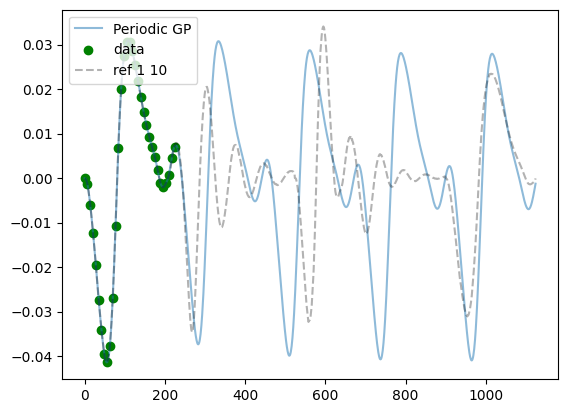

In [10]:
for i in range(1, 2):
    for j in range(10, 11):
        x_Hale = np.arange(0, nodes_tr.shape[2] // 84, 7)
        y_Hale = nodes_tr[i, j, x_Hale]
        sm = KRG(corr=k, noise0=[1e-6], hyper_opt="Cobyla", n_start=15)
        sm.set_training_values(x_Hale, y_Hale)
        sm.train()
        print(k.theta)

        X_test = np.arange(0, nodes_tr.shape[2], 1)
        X_test = X_test[:1125]
        mean_y_pred = sm.predict_values(X_test)

        plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.5, label="Periodic GP")

        plt.scatter(x_Hale, y_Hale, color="g", label="data")
        plt.plot(
            X_test,
            nodes_tr[i, j, X_test],
            color="black",
            linestyle="dashed",
            alpha=0.3,
            label=f"ref {i} {j}",
        )
        plt.legend(loc="upper left")

        plt.show()